In [6]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset_new_v2 import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep_new_v2 import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt
import glob
import pandas as pd

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['legend.fontsize']=11

fig_width = 6
fig_width_big = 12

In [3]:

folder_path = '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final/'
# folder_path = '../../../in-context-bldc-data/simulated/50_percent_with_alfa_beta_alt'


In [4]:
list_of_folders = glob.glob(os.path.join(folder_path, '*'))[:6]
print(list_of_folders)
identifiers = [list_of_folders[i].split("_")[-2][-9:] for i in range(len(list_of_folders))]
print(identifiers)

#### inertias [e-4]: I5 = 0.7, I13 = 1.4, I15 = 3.1, I9 = 5.8, I11 = 6.8, I7 = 8.8
order = [0, 4, 5, 2, 3, 1]
list_of_folders = [list_of_folders[j] for j in order]
identifiers = [identifiers[j] for j in order]
print(list_of_folders)
print(identifiers)

['../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia05_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia07_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia09_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia11_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia13_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia15_ki-0.0029-kp-3.0000']
['inertia05', 'inertia07', 'inertia09', 'inertia11', 'inertia13', 'inertia15']
['../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia05_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia13_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia15_ki-0.0029-kp-3.0000', '../data/CL_experim

In [ ]:

rmse_list_meta = []
rmse_list_ekf = []

for exp_idx in range(len(list_of_folders)):
    rmse_config_meta = []
    rmse_config_ekf = []
    exp_path = list_of_folders[exp_idx]
    csv_list = glob.glob(os.path.join(exp_path, "*.csv"))
    for file in csv_list:

        df = pd.read_csv(file)
        rmse_config_meta.append(   np.sqrt(  (   (   df["omega"].to_numpy()-df["omega_meta"].to_numpy()   )**2    ).mean()   )   )
        rmse_config_ekf.append(    np.sqrt(  (   (   df["omega"].to_numpy()-df["omega_ekf"].to_numpy()    )**2    ).mean()   )   )

    rmse_list_meta.append(rmse_config_meta)
    rmse_list_ekf.append(rmse_config_ekf)

# print(rmse_list_meta)


[[32.192453502505096, 48.496132856130735, 31.350511407827167, 37.46674049432356, 25.91958815076435, 32.45688757273204, 27.84092517867947, 42.49164546266554, 29.980225282489155, 36.45912589638475, 28.136441491290196, 32.72426312052115, 46.12591370403984, 30.427238938042603, 40.14843602503723], [35.455155719485234, 19.164337311127063, 39.520162862404405, 48.84145136125147, 50.38997513041779, 37.85276405470343, 28.055451141416498, 33.6266136844991, 28.514797759681056, 28.593608001325308, 21.151149262031964, 29.528653726977698, 45.66530903113629, 22.0663597519326, 50.81015425149284], [36.68734913237694, 29.349521560286885, 51.9102100501573, 47.15140876251082, 29.265867184027396, 32.734794259103836, 47.290373393516326, 32.25834733106071, 29.465465745685307, 42.74288718617281, 45.11229440762139, 53.49498003242278, 30.76158724965204, 51.86255016792229, 38.28426833270307], [42.958438090482296, 28.6021137377017, 40.38184268281417, 42.452291821296214, 39.0843945782603, 58.52833149327624, 46.8393

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])
['_set_edgecolor', '_set_facecolor', 'set_color', 'set_edgecolor', 'set_facecolor']


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


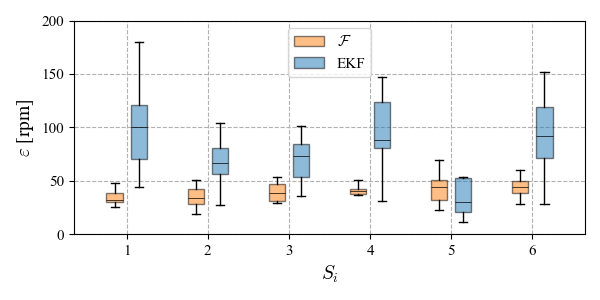

In [11]:

rmse_full_meta = np.column_stack(rmse_list_meta)
rmse_full_ekf = np.column_stack(rmse_list_ekf)
dx = 0.15
width = 0.2
# print(rmse_full.shape)

flierprops_meta = dict(marker='', markerfacecolor='tab:orange', markersize=4,
                  linestyle='none', markeredgecolor='none')
flierprops_ekf = dict(marker='', markerfacecolor='tab:blue', markersize=4,
                  linestyle='none', markeredgecolor='none')
fig = plt.figure(figsize=(6,3))
b_plot_meta = plt.boxplot(rmse_full_meta, positions=np.arange(6)+1-dx, widths=width, patch_artist=True, flierprops=flierprops_meta, label = r"$\mathcal{F}$")
b_plot_ekf= plt.boxplot(rmse_full_ekf, positions=np.arange(6)+1+dx, widths=width, patch_artist=True, flierprops=flierprops_ekf, label = r"EKF")

print(b_plot_ekf.keys())

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(b_plot_meta[element], color="black")
        plt.setp(b_plot_ekf[element], color="black")
for patch in b_plot_meta['boxes']:
    patch.set_facecolor("tab:orange")
    patch.set_edgecolor("black")
    patch.set_alpha(0.5)
for patch in b_plot_ekf['boxes']:
    patch.set_facecolor("tab:blue")
    patch.set_edgecolor("black")
    patch.set_alpha(0.5)

plt.setp(b_plot_meta["medians"], linewidth = 0.5)
plt.setp(b_plot_ekf["medians"], linewidth = 0.5)



print([method_name for method_name in dir(patch) if callable(getattr(patch, method_name)) and ("color" in method_name) and ("set" in method_name)])
x_tick_labels = [str(i + 1)  for i in range(len(list_of_folders))] 
plt.xticks(np.arange(6)+1, x_tick_labels)
plt.ylabel(r"$\varepsilon$ [rpm]")
plt.xlabel("$S_i$")
fig.tight_layout()
plt.legend()
plt.ylim([0,200])
plt.tight_layout()
plt.savefig("figures\\boxplot.pdf", dpi=300)
plt.show()


In [8]:

# for i in range(10):

#     y_full_np = y_full_all.cpu().numpy()  # Shape (seq_len, 1)
#     y_pred_np = y_pred_all.cpu().numpy()
#     # print(y_full_np.shape)
#     plt.figure(figsize=(10,4))
#     plt.plot(y_full_np[i])
#     plt.plot(y_pred_np[i])
#     plt.show()

#     # plt.figure(figsize=(10,4))
#     # plt.plot(y_full_np[i]/y_pred_np[i])
    
#     plt.show()
    